In [40]:
import numpy as np
import torch as th
import matplotlib.pyplot as plt


In [41]:
from engiopt.cgan_vae.cgan_vae import Encoder, Generator3D

from engiopt.metrics import dpp_diversity

In [42]:
from datasets import load_dataset

# Example: Load the heat conduction 3D dataset (replace with your actual dataset name)
dataset = load_dataset("IDEALLab/heat_conduction_3d_v0", split="train", cache_dir="/cluster/scratch/chatterer/SemesterProject/datasets")
print(dataset)



Dataset({
    features: ['volume', 'area', 'optimal_design'],
    num_rows: 361
})


In [43]:
# Access an example
example = dataset[0]

print("Dataset features:", dataset.features)
print("Number of rows:", len(dataset))
print("First example keys:", example.keys())
print("Volume:", example["volume"])
print("Area:", example["area"])
print("Optimal design shape:", np.array(example["optimal_design"]).shape)

Dataset features: {'volume': Value(dtype='float64', id=None), 'area': Value(dtype='float64', id=None), 'optimal_design': Sequence(feature=Sequence(feature=Sequence(feature=Value(dtype='float64', id=None), length=-1, id=None), length=-1, id=None), length=-1, id=None)}
Number of rows: 361
First example keys: dict_keys(['volume', 'area', 'optimal_design'])
Volume: 0.3
Area: 0.0
Optimal design shape: (51, 51, 51)


In [44]:
slices = example["optimal_design"]  # Replace "slices" with the actual key in your dataset
slices_tensor = th.tensor(slices, dtype=th.float32)

In [45]:
# Load trained models
encoder = Encoder(latent_dim=64)
generator = Generator3D(latent_dim=64, n_conds=2, design_shape=(64, 64, 64))

device = th.device("cuda" if th.cuda.is_available() else "cpu")
map_location = device if th.cuda.is_available() else th.device('cpu')

state_dict = th.load("/cluster/home/chatterer/SemesterProject/multiview_3d_vaegan.pth", map_location=map_location)
encoder.load_state_dict(state_dict["encoder"])
generator.load_state_dict(state_dict["generator"])
encoder.eval()
generator.eval()

encoder.to(device)
generator.to(device)
slices_tensor = slices_tensor.to(device)


In [46]:

# --- Extract a subset of XY slices from each volume ---
designs_3d = slices_tensor.unsqueeze(0).unsqueeze(1)  # (1, 1, D, H, W)
D, H, W = designs_3d.shape[2], designs_3d.shape[3], designs_3d.shape[4]
n_slices = min(8, D)  # You can set n_slices as desired (replace 16 with args.n_slices if available)
slice_indices = th.linspace(0, D - 1, n_slices).long()
slices = designs_3d[:, :, slice_indices, :, :]  # (1, 1, n_slices, H, W)
slices = slices.permute(0, 2, 1, 3, 4)  # (1, n_slices, 1, H, W)
slices = slices.reshape(-1, 1, H, W)  # (n_slices, 1, H, W)
# Encode slices to latent vector
with th.no_grad():
    mu, logvar = encoder(slices)
    mu = mu.mean(dim=0, keepdim=True)  # Mean pool over slices
    z_encoded = mu  # Or use reparameterize(mu, logvar)

In [47]:
# Choose a condition (example: [0.5, 0.5])
cond = th.tensor([[0.5, 0.5]], dtype=th.float32).to(device)
cond = cond.view(1, 2, 1, 1, 1)

In [48]:
# Generate 3D design from encoded slices
gen_from_slices = generator(z_encoded.view(1, -1, 1, 1, 1), cond)
gen_from_slices_np = gen_from_slices.squeeze(0).cpu().detach().numpy()

# Generate 3D design from random noise
z_random = th.randn_like(z_encoded)
gen_from_noise = generator(z_random.view(1, -1, 1, 1, 1), cond)
gen_from_noise_np = gen_from_noise.squeeze(0).cpu().detach().numpy()


In [60]:
# Load multiple examples from dataset
n_examples = 50
examples = [dataset[i] for i in range(min(n_examples, len(dataset)))]
multiple_designs = [th.tensor(ex["optimal_design"], dtype=th.float32) for ex in examples]

# Stack and reshape
designs_array = th.stack(multiple_designs, dim=0).numpy()
designs_for_dpp = designs_array.reshape(designs_array.shape[0], -1)

# Compute DPP diversity
dpp_value = dpp_diversity(designs_for_dpp, sigma=10)
print(f"DPP diversity for {n_examples} dataset designs: {dpp_value}")

DPP diversity for 50 dataset designs: 3.952519724179664e-12


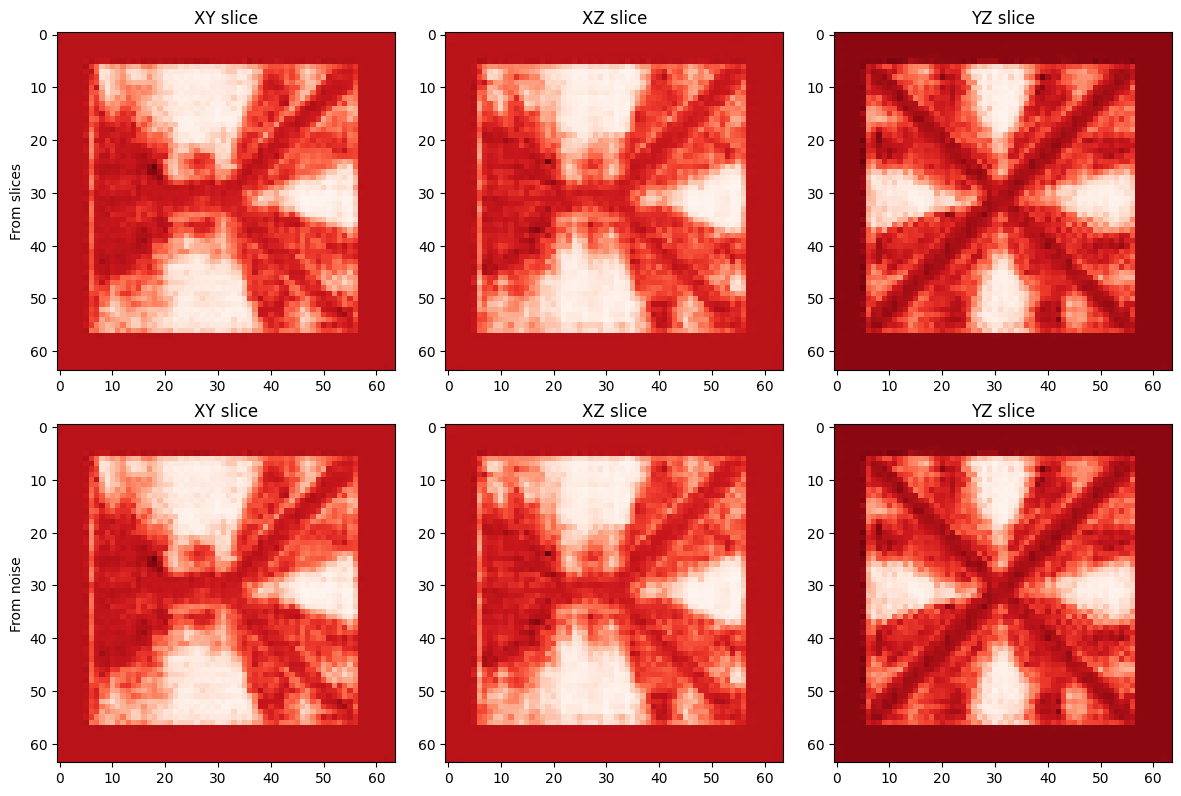

In [50]:
# Plot central slices for comparison
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
for i, vol in enumerate([gen_from_slices_np, gen_from_noise_np]):
    vol = np.squeeze(vol)  # Remove leading singleton dimension if present
    d, h, w = vol.shape
    axes[i, 0].imshow(vol[d // 2, :, :], cmap="Reds_r")
    axes[i, 0].set_title("XY slice")
    axes[i, 1].imshow(vol[:, h // 2, :], cmap="Reds_r")
    axes[i, 1].set_title("XZ slice")
    axes[i, 2].imshow(vol[:, :, w // 2], cmap="Reds_r")
    axes[i, 2].set_title("YZ slice")
axes[0, 0].set_ylabel("From slices")
axes[1, 0].set_ylabel("From noise")
plt.tight_layout()
plt.show()

/tmp/ipykernel_1531803/472791048.py:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


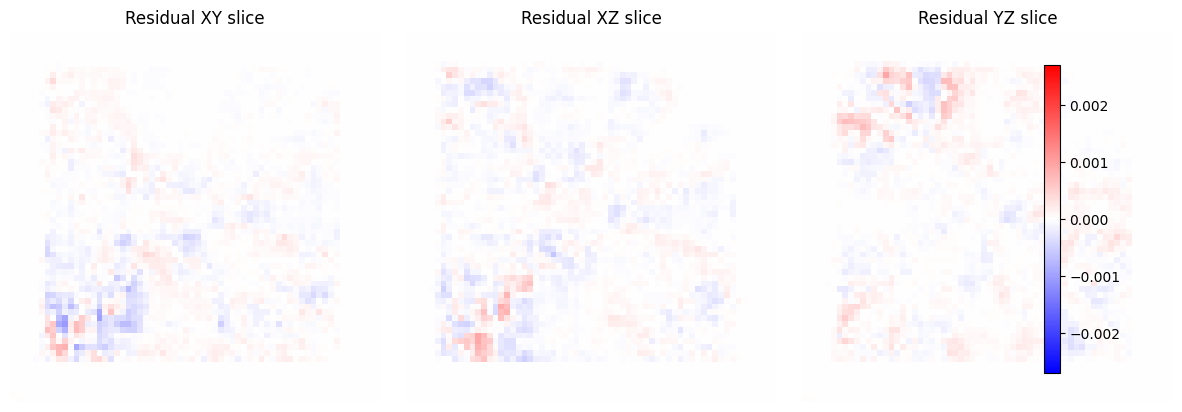

In [51]:
# Remove leading singleton dimension if present
residuals_vol = np.squeeze(gen_from_slices_np - gen_from_noise_np)

# Plot central slices for comparison
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# If residuals_vol has shape (D, H, W), get central indices:
central_indices = [s // 2 for s in residuals_vol.shape]

axes[0].imshow(residuals_vol[central_indices[0], :, :], cmap="bwr", vmin=-np.max(np.abs(residuals_vol)), vmax=np.max(np.abs(residuals_vol)))
axes[0].set_title("Residual XY slice")
axes[1].imshow(residuals_vol[:, central_indices[1], :], cmap="bwr", vmin=-np.max(np.abs(residuals_vol)), vmax=np.max(np.abs(residuals_vol)))
axes[1].set_title("Residual XZ slice")
axes[2].imshow(residuals_vol[:, :, central_indices[2]], cmap="bwr", vmin=-np.max(np.abs(residuals_vol)), vmax=np.max(np.abs(residuals_vol)))
axes[2].set_title("Residual YZ slice")
im = axes[0].imshow(residuals_vol[central_indices[0], :, :], cmap="bwr", vmin=-np.max(np.abs(residuals_vol)), vmax=np.max(np.abs(residuals_vol)))
fig.colorbar(im, ax=axes, orientation="vertical", fraction=0.025, pad=0.04)
for ax in axes:
    ax.axis("off")
plt.tight_layout()
plt.show()
# Add colorbar to the residual plots

In [52]:
# Statistical analysis of residuals
mean_residual = np.mean(residuals_vol)
std_residual = np.std(residuals_vol)
min_residual = np.min(residuals_vol)
max_residual = np.max(residuals_vol)
median_residual = np.median(residuals_vol)
percentile_25 = np.percentile(residuals_vol, 25)
percentile_75 = np.percentile(residuals_vol, 75)

print("Residuals Statistical Analysis:")
print(f"Mean: {mean_residual:.4f}")
print(f"Std Dev: {std_residual:.4f}")
print(f"Min: {min_residual:.4f}")
print(f"Max: {max_residual:.4f}")
print(f"Median: {median_residual:.4f}")
print(f"25th Percentile: {percentile_25:.4f}")
print(f"75th Percentile: {percentile_75:.4f}")

Residuals Statistical Analysis:
Mean: 0.0000
Std Dev: 0.0001
Min: -0.0027
Max: 0.0025
Median: 0.0000
25th Percentile: -0.0000
75th Percentile: 0.0000


In [53]:
# Compute residuals between generated and original slices
# Crop generated volume to match original slice size (center crop from 64x64x64 to 51x51x51)
def center_crop_3d(arr, target_shape):
    start = [(s - t) // 2 for s, t in zip(arr.shape, target_shape)]
    end = [start[i] + target_shape[i] for i in range(3)]
    return arr[start[0]:end[0], start[1]:end[1], start[2]:end[2]]

gen_cropped_vol_slices = center_crop_3d(gen_from_slices_np.squeeze(), (51, 51, 51))
orig_vol = slices_tensor.cpu().numpy()
residuals_vol = gen_cropped_vol_slices - orig_vol



/tmp/ipykernel_1531803/2878710464.py:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


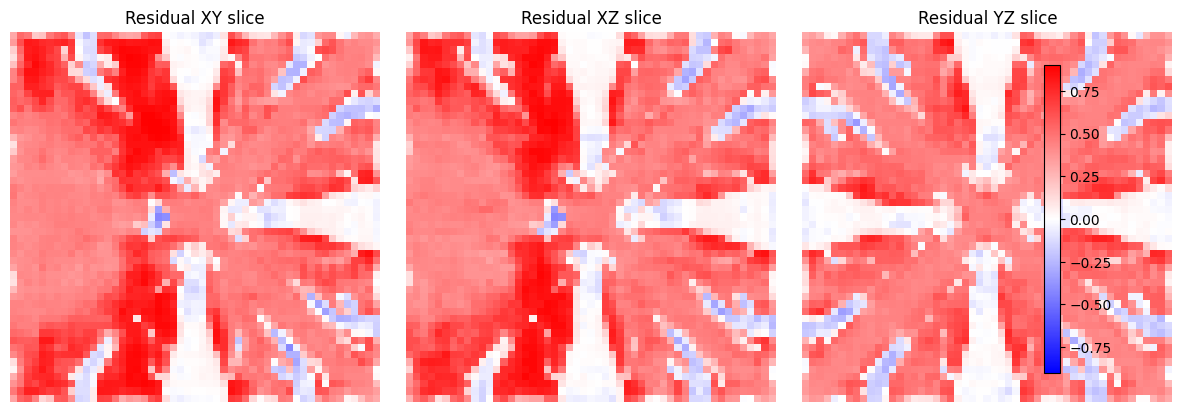

In [54]:
# Plot central slices for comparison
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(residuals_vol[25, :, :], cmap="bwr", vmin=-np.max(np.abs(residuals_vol)), vmax=np.max(np.abs(residuals_vol)))
axes[0].set_title("Residual XY slice")
axes[1].imshow(residuals_vol[:, 25, :], cmap="bwr", vmin=-np.max(np.abs(residuals_vol)), vmax=np.max(np.abs(residuals_vol)))
axes[1].set_title("Residual XZ slice")
axes[2].imshow(residuals_vol[:, :, 25], cmap="bwr", vmin=-np.max(np.abs(residuals_vol)), vmax=np.max(np.abs(residuals_vol)))
axes[2].set_title("Residual YZ slice")
im = axes[0].imshow(residuals_vol[25, :, :], cmap="bwr", vmin=-np.max(np.abs(residuals_vol)), vmax=np.max(np.abs(residuals_vol)))
fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.025, pad=0.04)
for ax in axes:
    ax.axis('off')
plt.tight_layout()
plt.show()
# Add colorbar to the residual plots


In [55]:
# Statistical analysis of residuals
mean_residual = np.mean(residuals_vol)
std_residual = np.std(residuals_vol)
min_residual = np.min(residuals_vol)
max_residual = np.max(residuals_vol)
median_residual = np.median(residuals_vol)
percentile_25 = np.percentile(residuals_vol, 25)
percentile_75 = np.percentile(residuals_vol, 75)

print("Residuals Statistical Analysis:")
print(f"Mean: {mean_residual:.4f}")
print(f"Std Dev: {std_residual:.4f}")
print(f"Min: {min_residual:.4f}")
print(f"Max: {max_residual:.4f}")
print(f"Median: {median_residual:.4f}")
print(f"25th Percentile: {percentile_25:.4f}")
print(f"75th Percentile: {percentile_75:.4f}")

Residuals Statistical Analysis:
Mean: 0.3543
Std Dev: 0.2535
Min: -0.4989
Max: 0.9022
Median: 0.4288
25th Percentile: 0.2461
75th Percentile: 0.4972
